In [15]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import time

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.ising.common import sample_most_likely

import logging
from qiskit.aqua import set_qiskit_aqua_logging

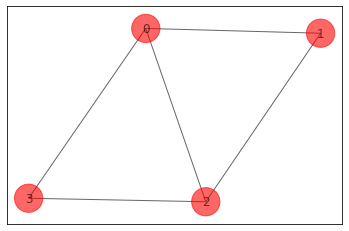

In [16]:
# generate a graph

n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
G.add_weighted_edges_from(E)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

In [18]:
# build a weight matrix from G
w = np.zeros([n,n])
for i, j, data in G.edges.data():
    w[i][j] = data['weight']
    w[j][i] = data['weight']
print(w)

[[0. 1.]
 [1. 0.]]


In [19]:
def get_operator(weight_matrix):
    """Generate Hamiltonian for the max-cut problem of a graph.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        WeightedPauliOperator: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    from qiskit.quantum_info import Pauli
    from qiskit.aqua.operators import WeightedPauliOperator
    
    num_nodes = weight_matrix.shape[0]
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=np.bool)
                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[i] = True
                z_p[j] = True
                print(x_p, z_p)
                print(Pauli(z_p, x_p))
                pauli_list.append([0.5 * weight_matrix[i, j], Pauli(z_p, x_p)])
                shift -= 0.5 * weight_matrix[i, j]
    return WeightedPauliOperator(paulis=pauli_list), shift

In [20]:
H = get_operator(w)[0]
print(H.print_details())
print(H.to_dict())

[False False] [ True  True]
ZZ
ZZ	(0.5+0j)

{'paulis': [{'label': 'ZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]}


In [21]:
from qiskit.quantum_info import Pauli
ixzy = Pauli([True, True, False, False], [True, False, True, False])
print(ixzy)

IXZY


In [22]:
print(ixzy.to_instruction())

In [23]:
instr = ixzy.to_instruction()

In [24]:
instr.qasm()

'Pauli:IXZY'

In [25]:
instr.definition

[(<qiskit.extensions.standard.y.YGate at 0x1100e50d0>,
  [Qubit(QuantumRegister(4, 'q'), 0)],
  []),
 (<qiskit.extensions.standard.z.ZGate at 0x1100e5790>,
  [Qubit(QuantumRegister(4, 'q'), 1)],
  []),
 (<qiskit.extensions.standard.x.XGate at 0x1100e5ed0>,
  [Qubit(QuantumRegister(4, 'q'), 2)],
  []),
 (<qiskit.extensions.standard.iden.IdGate at 0x1100e55d0>,
  [Qubit(QuantumRegister(4, 'q'), 3)],
  [])]

In [26]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5,4)

In [27]:
qc.draw()

In [28]:
instr

In [29]:
qc.append(instr, [0,1,2,3], [0,1,2,3])

In [30]:
qc.draw()